In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import utils as utils
from importlib import reload



2023-09-07 09:50:56.768370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 09:50:58.453771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [83]:
aapl = yf.download('aapl',start = '2000-01-01',end = '2023-08-25')
vix = yf.download('^VIX',start = '2000-01-01',end = '2023-08-25')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [84]:
tstart = 2016
tend = 2021

aapl['Vix'] = vix['High']

aapl['VixCHG'] = aapl['Vix'].pct_change() * 100
aapl['VixCHG'].fillna(0, inplace=True)

aapl['CloseCHG'] = aapl['Close'].pct_change() * 100
aapl['CloseCHG'].fillna(0, inplace=True)

aapl.loc[:, "minMaxPctChgClCl"] = utils.quantile_pctChg_rescale(aapl.CloseCHG,(.1,.9),(-1,1))

aapl['VolCHG'] = aapl['Volume'].pct_change() * 100
aapl['VolCHG'].fillna(0, inplace=True)

aapl['HighLow'] = (aapl['High'] - aapl['Low'])/aapl['High'] * 100
aapl.head()
feature_list = ['minMaxPctChgClCl','VolCHG', 'HighLow', "Vix"]
# feature_list = ['CloseCHG','Close']

training_set, test_set = utils.train_test_split(aapl,tstart, tend, feature_list)
training_set

array([[ 3.13034096e-02,  6.53522290e+01,  3.19825630e+00],
       [-9.17486060e-01, -1.75292020e+01,  3.24987705e+00],
       [-7.16496338e-01,  2.27033034e+01,  2.44212165e+00],
       ...,
       [ 1.83811465e-02, -2.12212377e+01,  1.37851156e+00],
       [-2.40846909e-01, -4.13142814e+00,  1.37343462e+00],
       [-1.29436239e-01,  7.17598247e+00,  1.09914706e+00]])

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = StandardScaler()# 

In [86]:
import seaborn as sns
training_set_scaled = scaler.fit_transform(training_set)



In [87]:
n_steps = 2
features = 3
reload(utils)
X_train, y_train = utils.split_sequence(training_set_scaled, n_steps)
# X_train_scaled, y_train_scaled = utils.split_sequence(training_set_scaled, n_steps)
# display(X_train)
# for y in y_train:
#     display(y)
import seaborn as sns
# sns.histplot(y_train)
# sns.histplot(X_train[:,0,1])
# np.sum(y_train_scaled > 0)/len(y_train_scaled)

<Axes: ylabel='Count'>

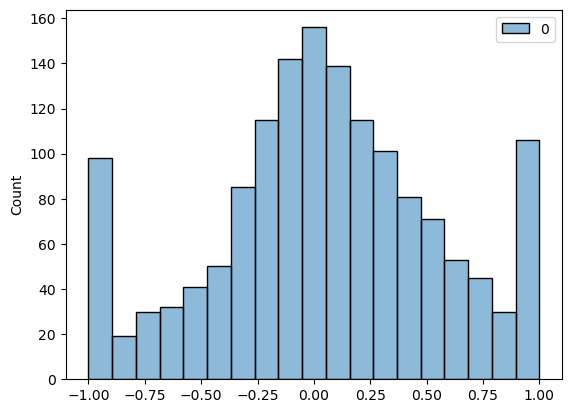

In [88]:
sns.histplot(y_train)

In [89]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [90]:
X_train_reshaped = X_train.reshape(-1,n_steps*features)
X_train_reshaped


array([[ 0.03130341, -0.18230191, -0.44329258, -0.91748606, -0.67851325,
        -0.43288329],
       [-0.91748606, -0.67851325, -0.43288329, -0.71649634, -0.43764114,
        -0.59576655],
       [-0.71649634, -0.43764114, -0.59576655, -1.        , -0.46304787,
        -0.34308561],
       ...,
       [ 0.84116752, -0.51608393, -0.71380155, -0.2111539 , -0.53980529,
        -0.77684232],
       [-0.2111539 , -0.53980529, -0.77684232,  0.01838115, -0.70061747,
        -0.81024272],
       [ 0.01838115, -0.70061747, -0.81024272, -0.24084691, -0.59830074,
        -0.81126648]])

In [91]:
n_clusters = 4  # You can adjust this based on your needs
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_train_reshaped)

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa028283ac0>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()


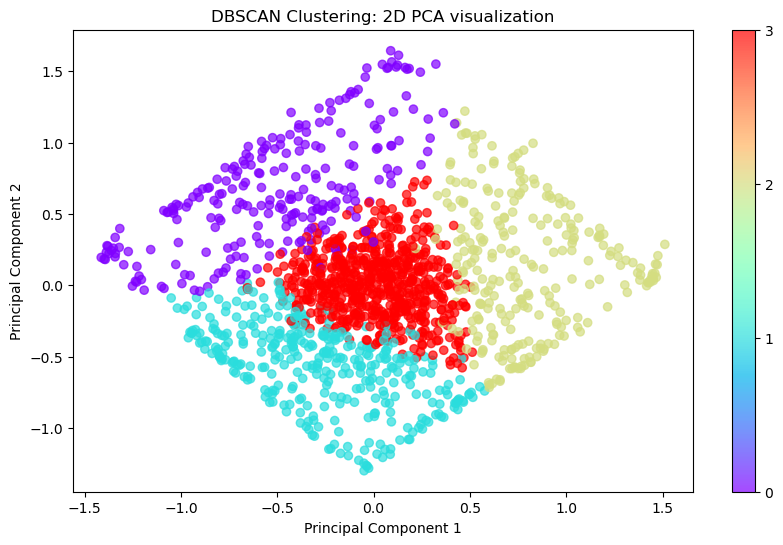

In [92]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_reshaped)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels, cmap='rainbow', alpha=0.7)
plt.title('DBSCAN Clustering: 2D PCA visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=np.unique(labels))
plt.show()


In [93]:
display(labels.shape)
display(y_train.shape)

(1509,)

(1509, 1)

In [94]:
# Flatten y_train to make it 1D
y_train_flattened = y_train.flatten()

# Create the DataFrame with flattened y_train and labels
df = pd.DataFrame({'label': labels, 'target': y_train_flattened})

# Compute the mean target value for each cluster
cluster_averages = df.groupby('label').mean()

df['avg_target'] = cluster_averages
df.head()
display(df['label'].value_counts())
display(cluster_averages)
display(df.describe())

3    638
1    358
2    267
0    246
Name: label, dtype: int64

,target
label,
0,0.068630
1,0.046939
2,0.025960
3,0.056013


,label,target,avg_target
count,1509.00000,1509.000000,4.000000
mean,1.85951,0.050599,0.049385
std,1.13721,0.508033,0.017972
min,0.00000,-1.000000,0.025960
25%,1.00000,-0.237005,0.041694
50%,2.00000,0.040479,0.051476
75%,3.00000,0.375616,0.059167
max,3.00000,1.000000,0.068630


In [95]:

cluster_X_train, cluster_y_train = utils.removeOutliers(X_train,y_train,labels)

In [96]:
display(X_train.shape)
display(y_train.mean())
display(cluster_y_train.mean())

(1509, 2, 3)

0.05059927464590324

0.05059927464590324

In [108]:
model_lstm = Sequential()

# Using Bidirectional LSTM for the first layer
model_lstm.add(Bidirectional(LSTM(units=300, activation='tanh', return_sequences=True), input_shape=(None, features+n_clusters)))
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(GRU(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(GRU(units=100, activation='tanh', return_sequences=True))  # Changed number of units to 250
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=100, activation='tanh'))  # Changed number of units to 100
model_lstm.add(BatchNormalization())  # Batch normalization
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1))

# Using Adam optimizer with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-5)

model_lstm.compile(optimizer=optimizer, loss="mse")
model_lstm.summary()







2023-09-07 10:12:12.948742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-07 10:12:12.949670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-07 10:12:12.950428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, None, 600)        739200    
 nal)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, None, 600)        2400      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, None, 600)         0         
                                                                 
 lstm_13 (LSTM)              (None, None, 250)         851000    
                                                                 
 batch_normalization_13 (Bat  (None, None, 250)        1000      
 chNormalization)                                                
                                                      

2023-09-07 10:12:13.734753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-07 10:12:13.735747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-07 10:12:13.736453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [109]:
model_lstm.fit(cluster_X_train,cluster_y_train,batch_size=30, epochs=100)

Epoch 1/100


2023-09-07 10:12:17.011825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-07 10:12:17.012977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-07 10:12:17.013941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 [==============================] - 8s 20ms/step - loss: 0.9787
Epoch 2/100
51/51 [==============================] - 1s 19ms/step - loss: 0.5939
Epoch 3/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5448
Epoch 4/100
51/51 [==============================] - 1s 19ms/step - loss: 0.5098
Epoch 5/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4944
Epoch 6/100
51/51 [==============================] - 1s 19ms/step - loss: 0.4362
Epoch 7/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4231
Epoch 8/100
51/51 [==============================] - 1s 19ms/step - loss: 0.3770
Epoch 9/100
51/51 [==============================] - 1s 20ms/step - loss: 0.3708
Epoch 10/100
51/51 [==============================] - 1s 19ms/step - loss: 0.3500
Epoch 11/100
51/51 [==============================] - 1s 20ms/step - loss: 0.3369
Epoch 12/100
51/51 [==============================] - 1s 19ms/step - loss: 0.3277
Epoch 13/100
51/51 [=================

In [99]:
dataset_total = aapl.loc[:,feature_list]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values

# inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)
# Split into samples
X_test, y_test = utils.split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

In [100]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

    # Get the cluster labels for the test data
cluster_assignments = kmeans.predict(X_test_reshaped)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa042254e50>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


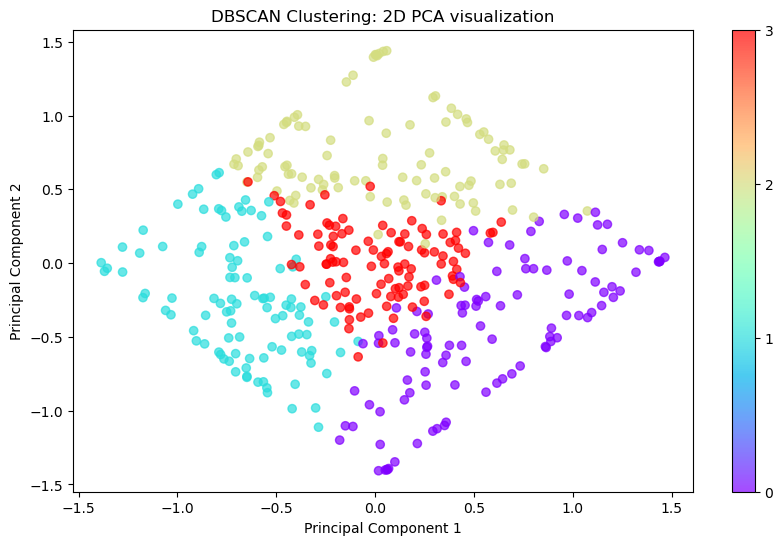

In [101]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_reshaped)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=cluster_assignments, cmap='rainbow', alpha=0.7)
plt.title('DBSCAN Clustering: 2D PCA visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=np.unique(cluster_assignments))
plt.show()


In [102]:
X_test.shape

(413, 2, 3)

In [103]:
cluster_X_test, cluster_y_test = utils.removeOutliers(X_test,y_test,cluster_assignments)
cluster_X_test.shape

(413, 2, 7)

In [104]:
np.sum(y_train > 0)/len(y_train)

0.5407554671968191

In [105]:
predicted_stock_price = model_lstm.predict(cluster_X_test)

# padded_predictions = np.zeros((predicted_stock_price.shape[0], features))

# padded_predictions[:, 0] = predicted_stock_price.squeeze() 
# inverse_transformed_predictions = scaler.inverse_transform(padded_predictions)
# final_predictions = inverse_transformed_predictions[:, 0]

2023-09-07 10:10:11.034575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-07 10:10:11.035702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-07 10:10:11.036486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 1s 4ms/step


In [106]:
results = pd.DataFrame(cluster_y_test, predicted_stock_price.reshape(-1))
results = results.reset_index()
results.columns = ['predicted','real']
results

,predicted,real
0,-0.071673,0.915466
1,0.133372,-0.464672
2,0.158660,-0.973890
3,0.246236,-0.611186
4,-0.063776,0.036186
...,...,...
408,0.099668,0.103106
409,0.085660,0.283263
410,-0.081985,0.289419
411,-0.094230,0.803605


In [107]:
results['same'] = ((results['predicted'] > 0) & (results['real'] > 0)) | ((results['predicted'] < 0) & (results['real'] < 0))
results['same'].sum() / len(results) * 100

44.794188861985475

In [204]:
results.describe()

,predicted,real
count,272.000000,272.000000
mean,-0.022655,0.069316
std,0.009859,0.551814
min,-0.048410,-1.000000
25%,-0.028697,-0.279721
50%,-0.023724,0.065201
75%,-0.016980,0.477121
max,0.006533,1.000000


In [255]:
len(results[results['real'] > 0 ])

160